In [2]:
import pandas as pd 
import numpy as np
from dealib import dea
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_excel('Data.xlsx', sheet_name = 'Fact_Academy')
data = data[data.Year.isin([2016, 2021])].reset_index(drop = True)
data_original = data.copy()
print(data.shape)
data.head(3)

(32, 14)


,Institution_YearCode,Year,Students,StudentsB.S,StudentsPhd,StudentsM.S,First_Year_Students,StudentsB.S.c_Engineering,StudentsM.S.c_Engineering,StudentsP.H.D_Engineering,Number_of_Degree_Recipients,Number_of_Bachelor's_Degree_Recipients,Number_of_Master's_Degree_Recipients,Number_of_Doctorate_Degree_Recipients
0,12021,2021,21817,13212,2329,6119.0,4356,357,0,12,5458,2801,2161,383
1,12016,2016,20171,11573,2224,6209.0,4720,327,3,7,5402,2888,2148,278
2,22021,2021,18428,12580,1668,4089.0,4206,5127,797,429,5194,3103,1744,256


In [3]:
####### Create Data #######

# Institution Type
dim_institute = fact_expenses = pd.read_excel('Data.xlsx', sheet_name = 'Dim_Institutions_YearCode')

# Institution Names 
institute_name = fact_expenses = pd.read_excel('Data.xlsx', sheet_name = 'Dim_Institutions')
institute_name = institute_name.drop(['InstitutionOpenAlex_ID'], axis = 1)

# Expenses
fact_expenses = pd.read_excel('Data.xlsx', sheet_name = 'Expanses_Orederd1')
fact_expenses = fact_expenses[(fact_expenses.Expanse_Code == 1) & (fact_expenses.Year.isin([2016, 2021]))].drop('Expanse_Code', axis = 1)
fact_expenses = fact_expenses.rename(columns = {'Amount': 'Expenses'}).reset_index(drop = True)

# Incomes
fact_incomes = pd.read_excel('Data.xlsx', sheet_name = 'Expanses_Orederd1')
fact_incomes = fact_incomes[(fact_incomes.Expanse_Code == 5) & (fact_incomes.Year.isin([2016, 2021]))].drop('Expanse_Code', axis = 1)
fact_incomes = fact_incomes.rename(columns = {'Amount': 'Incomes'}).reset_index(drop = True)

# Administratif Staff
admin_staff = pd.read_excel('Data.xlsx', sheet_name = 'Staff_Oredered1')
admin_staff = admin_staff[(admin_staff.Staff_Type == 4) & (admin_staff.Year.isin([2016, 2021]))].drop('Staff_Type', axis = 1)
admin_staff = admin_staff.rename(columns = {'Staff_Amount': 'Administratif_Staff'}).reset_index(drop = True)

# Senior Academic Staff
senior_staff = pd.read_excel('Data.xlsx', sheet_name = 'Staff_Oredered1')
senior_staff = senior_staff[(senior_staff.Staff_Type == 1) & (senior_staff.Year.isin([2016, 2021]))].drop('Staff_Type', axis = 1)
senior_staff = senior_staff.rename(columns = {'Staff_Amount': 'Senior_Staff'}).reset_index(drop = True)

In [4]:
data_exp1 = data.copy()
data_exp1 = data_exp1[['Institution_YearCode', 'Year', 'Students']]

data_exp1 = pd.merge(data_exp1, fact_expenses, on = ['Institution_YearCode', 'Year'], how = 'left')
data_exp1 = pd.merge(data_exp1, fact_incomes, on = ['Institution_YearCode', 'Year'], how = 'left')
data_exp1 = pd.merge(data_exp1, admin_staff, on = ['Institution_YearCode', 'Year'], how = 'left')
data_exp1 = pd.merge(data_exp1, senior_staff, on = ['Institution_YearCode', 'Year'], how = 'left')
data_exp1 = pd.merge(data_exp1, dim_institute, on = ['Institution_YearCode'], how = 'left')
data_exp1 = pd.merge(data_exp1, institute_name, on = ['Institution_Code'], how = 'left')
data_exp1 = data_exp1.sort_values(by = 'Year').drop('Institution_Code', axis = 1).reset_index(drop = True)
data_exp1.head(3)

,Institution_YearCode,Year,Students,Expenses,Incomes,Administratif_Staff,Senior_Staff,Institution_Name,Institution_TypeID
0,252016,2016,3789,120416,141394,181.15,114.26,HIT,2
1,712016,2016,1570,55683,78101,84.1,38.05,Azrieli,2
2,672016,2016,3677,139911,166066,167.4,126.5,Machon Lev,2


In [5]:
def run_dea_for_years(data, years, input_vars, output_vars, Institution_TypeID=None, method = "crs", lambdas=False, graph=False):
    results = []
    type_institute = 'Universities' if Institution_TypeID == 1 else 'Colleges'

    for year in years:
        df = data[(data["Institution_TypeID"] == Institution_TypeID) & (data["Year"] == year)].copy()
        inputs = df[input_vars].values.tolist()
        outputs = df[output_vars].values.tolist()
        dmu_names = df["Institution_Name"].tolist()

        dea_model = dea(inputs, outputs, rts= method, orientation="input")
        df["Efficiency"] = dea_model.eff
        df["Year"] = year
        results.append(df[["Institution_Name", "Efficiency", "Year"]])

        if lambdas:
            lambda_values = np.array(dea_model.lambdas)
            plt.figure(figsize=(18, 4))
            sns.heatmap(lambda_values, annot=True, cbar=False, cmap='Blues',
                        xticklabels=dmu_names, yticklabels=dmu_names)
            plt.title(f"Lambda Heatmap - {year}", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

    df_all = pd.concat(results)

    if graph and len(years) > 1:
        pivot = df_all.pivot(index="Institution_Name", columns="Year", values="Efficiency").reset_index()
        pivot = pivot.sort_values(by=years[0], ascending=True)

        bar_width = 0.25
        spacing = 0.15
        indices = np.arange(len(pivot)) * (bar_width * len(years) + spacing)

        plt.figure(figsize=(15, 6))

        base_colors = sns.color_palette("Blues", len(years) + 2)[2:]

        for i, year in enumerate(years):
            scores = pivot[year]
            bars = plt.barh(
                indices + i * bar_width, scores, height=bar_width,
                label=str(year), color=base_colors[i]
            )
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.01 if width >= 0 else width - 0.05,
                         bar.get_y() + bar.get_height() / 2,
                         f"{width:.2f}", va='center', fontsize=9)

        plt.yticks(indices + bar_width * (len(years) - 1) / 2, pivot["Institution_Name"], fontsize=11)
        plt.xlabel("Efficiency Score", fontsize=12)
        plt.title(f"DEA Scores - {' / '.join(map(str, years))} - {type_institute}", fontsize=16, fontweight='bold')
        plt.legend(title="Years", loc='lower right')
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.show()

    return df_all



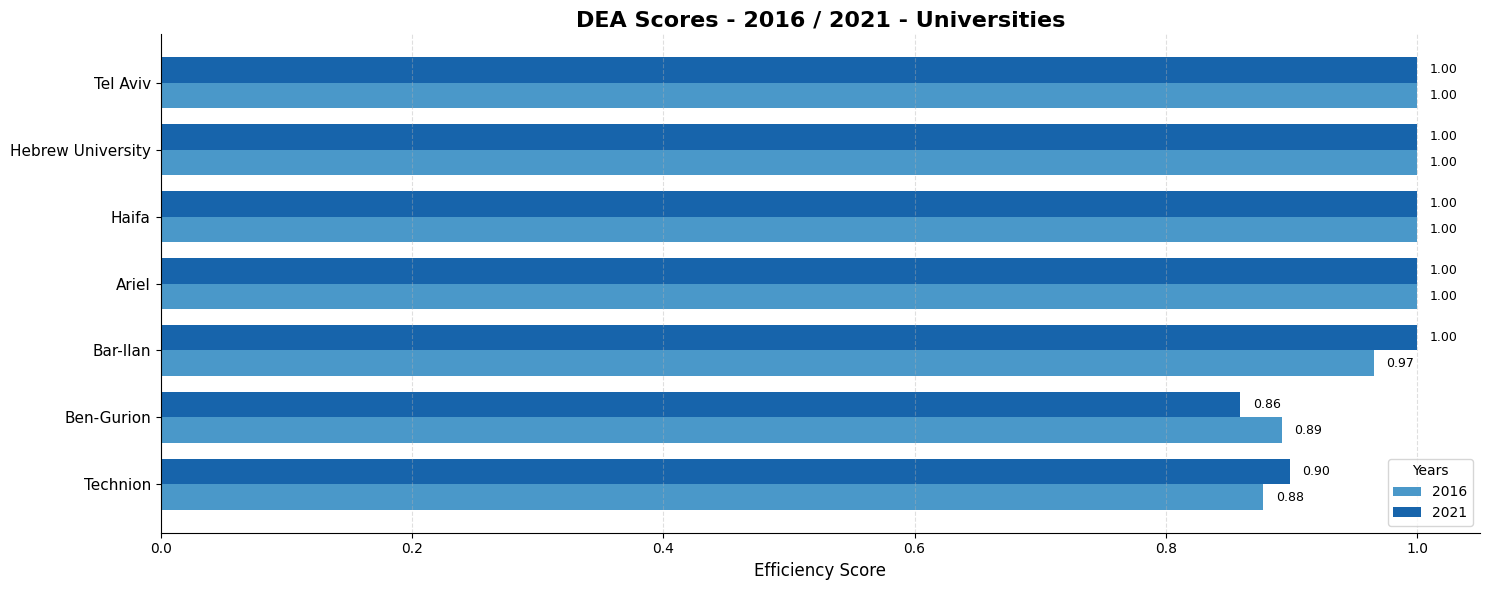

,Institution_Name,Efficiency,Year
4,Ariel,1.000000,2016
9,Technion,0.877602,2016
11,Haifa,1.000000,2016
12,Hebrew University,1.000000,2016
13,Ben-Gurion,0.892313,2016
14,Tel Aviv,1.000000,2016
15,Bar-Ilan,0.965357,2016
19,Tel Aviv,1.000000,2021
21,Technion,0.898770,2021
22,Ariel,1.000000,2021


In [6]:
run_dea_for_years(
    data=data_exp1,
    years=[2016, 2021],
    input_vars=["Expenses", "Senior_Staff", "Administratif_Staff"],
    output_vars=["Students", "Incomes"],
    Institution_TypeID=1,
    method = "crs",
    lambdas=False,
    graph=True
)

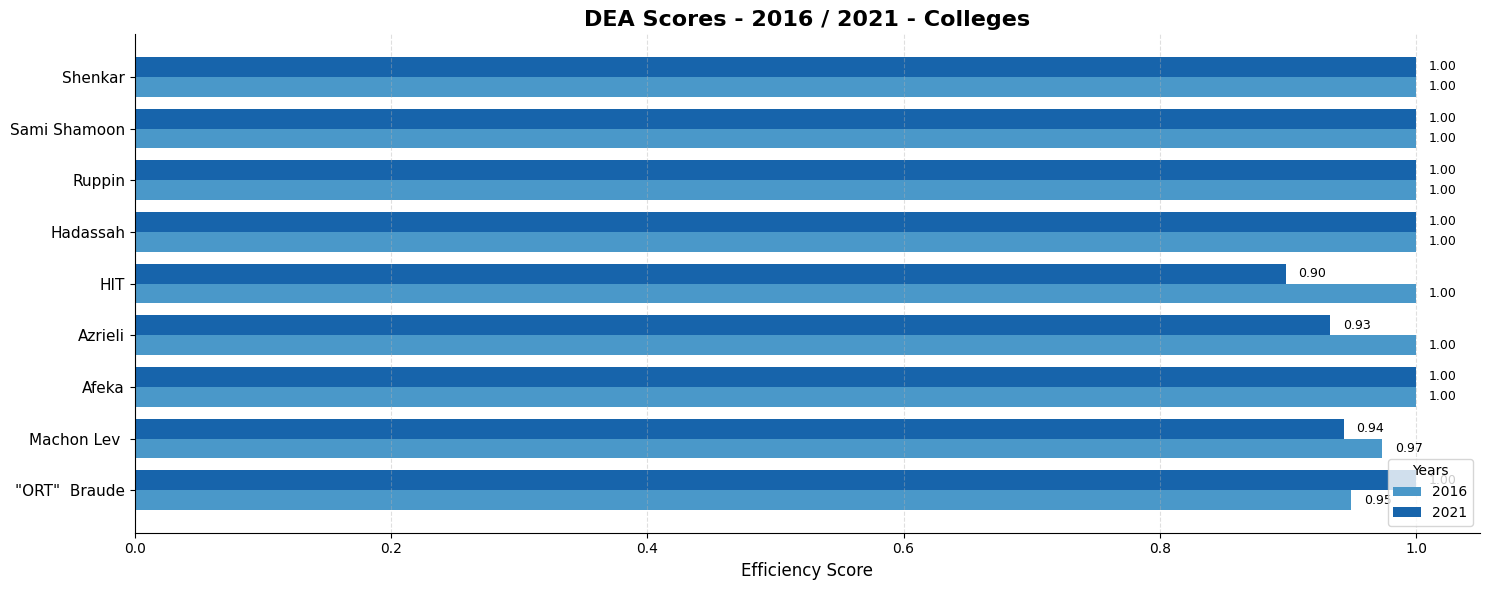

,Institution_Name,Efficiency,Year
0,HIT,1.000000,2016
1,Azrieli,1.000000,2016
2,Machon Lev,0.973852,2016
3,Hadassah,1.000000,2016
5,Sami Shamoon,1.000000,2016
6,Shenkar,1.000000,2016
7,Afeka,1.000000,2016
8,Ruppin,1.000000,2016
10,"""ORT"" Braude",0.949333,2016
16,Afeka,1.000000,2021


In [7]:
run_dea_for_years(
    data=data_exp1,
    years=[2016, 2021],
    input_vars=["Expenses", "Senior_Staff", "Administratif_Staff"],
    output_vars=["Students", "Incomes"],
    Institution_TypeID=2,
    lambdas=False,
    graph=True
)